# CLEAN FOLDERS - IMPORT DATA - RENAME FOLDERS - PRINT DB STRUCTURE.


In [ ]:
# BLOCK 0: Clean Dataset Folder
import os
import shutil

def cleanup_dataset():
    """
    Remove existing dataset folder to start fresh
    """
    dataset_path = '/content/dataset'

    if os.path.exists(dataset_path):
        print("Removing existing dataset folder...")
        shutil.rmtree(dataset_path)
        print("Dataset folder cleaned!")
    else:
        print("No existing dataset folder found")

    # Also remove any leftover zip file
    zip_path = '/content/dataset.zip'
    if os.path.exists(zip_path):
        os.remove(zip_path)
        print("Removed old dataset.zip")

    print("Ready for fresh import!")

# Run cleanup
cleanup_dataset()

No existing dataset folder found
Ready for fresh import!


In [ ]:
import gdown
import zipfile

# Your Google Drive sharing link
# https://drive.google.com/file/d/1pfyAN5XE4ULgnx9NHfMCgw9QK6KCee_l/view?usp=sharing

# Extract the file ID from the link
file_id = '1pfyAN5XE4ULgnx9NHfMCgw9QK6KCee_l'
url = f'https://drive.google.com/uc?id={file_id}'

print("Downloading dataset from Google Drive...")
output_path = '/content/dataset.zip'

# Download the file
gdown.download(url, output_path, quiet=False)

# Extract the dataset
print("Extracting dataset...")
with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

print("Dataset downloaded and extracted successfully!")

Downloading...
From (original): https://drive.google.com/uc?id=1pfyAN5XE4ULgnx9NHfMCgw9QK6KCee_l
From (redirected): https://drive.google.com/uc?id=1pfyAN5XE4ULgnx9NHfMCgw9QK6KCee_l&confirm=t&uuid=3d8c96df-dbd3-44bf-be3c-d3e9badec710
To: /content/dataset.zip
100%|██████████| 45.5M/45.5M [00:01<00:00, 38.6MB/s]


Extracting dataset...
Dataset downloaded and extracted successfully!


In [ ]:
import os
import shutil
from torchvision.datasets import ImageFolder # Import ImageFolder

# Rename folders to remove spaces
train_old = '/content/dataset/content/bone_data/train/not fractured'
train_new = '/content/dataset/content/bone_data/train/normal' # Corrected path
val_old = '/content/dataset/content/bone_data/val/not fractured'
val_new = '/content/dataset/content/bone_data/val/normal' # Corrected path

# Rename train folder
if os.path.exists(train_old):
    os.rename(train_old, train_new)
    print("Renamed train/not fractured -> train/normal")

# Rename val folder
if os.path.exists(val_old):
    os.rename(val_old, val_new)
    print("Renamed val/not fractured -> val/normal")

print("Folder renaming complete!")

# Verify the new structure
train_dataset_test = ImageFolder('/content/dataset/content/bone_data/train') # Corrected path
print(f"Classes after renaming: {train_dataset_test.classes}")

Renamed train/not fractured -> train/normal
Renamed val/not fractured -> val/normal
Folder renaming complete!
Classes after renaming: ['fractured', 'normal']


In [ ]:
# Add this block to check your dataset structure
import os
print("Dataset structure:")
for root, dirs, files in os.walk('/content/dataset'):
    level = root.replace('/content/dataset', '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files[:3]:  # Show first 3 files
        print(f'{subindent}{file}')
    if len(files) > 3:
        print(f'{subindent}... and {len(files)-3} more files')

Dataset structure:
dataset/
  content/
    bone_data/
      train/
        normal/
          49-rotated2-rotated1-rotated2-rotated1.jpg
          33-rotated1-rotated3-rotated1-rotated1.jpg
          10-rotated3-rotated2-rotated2-rotated1.jpg
          ... and 4380 more files
        fractured/
          107-rotated2-rotated2-rotated1.jpg
          21-rotated1-rotated1-rotated1.jpg
          35-rotated2-rotated2-rotated2.jpg
          ... and 4477 more files
      archive (6)/
      val/
        normal/
          1-rotated2-rotated2-rotated2.jpg
          2-rotated2-rotated1.jpg
          3-rotated1-rotated3.jpg
          ... and 237 more files
        fractured/
          8-rotated1-rotated3-rotated3.jpg
          1-rotated2-rotated2-rotated2.jpg
          2-rotated2-rotated1.jpg
          ... and 357 more files


DATA AUGMENTATION
======================================================
Change Flag True or False to enable data augmentation
======================================================

In [ ]:
# BLOCK: Data Augmentation Configuration
import torchvision.transforms as transforms

# Toggle this flag to enable/disable augmentation
USE_AUGMENTATION = True  # Set to False to disable augmentation

print(f"Data Augmentation: {'ENABLED' if USE_AUGMENTATION else 'DISABLED'}")

if USE_AUGMENTATION:
    # WITH Data Augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    print("Using augmented training transforms:")
    print("- Random horizontal flip (50%)")
    print("- Random rotation (±10°)")
    print("- Color jitter (brightness & contrast ±20%)")

else:
    # WITHOUT Data Augmentation (same as validation)
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    print("Using basic training transforms (no augmentation)")

# Validation transform (always the same - no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Validation/Test transforms: Basic resize + normalize only")
print("=" * 50)

Data Augmentation: ENABLED
Using augmented training transforms:
- Random horizontal flip (50%)
- Random rotation (±10°)
- Color jitter (brightness & contrast ±20%)
Validation/Test transforms: Basic resize + normalize only


# MODEL COMPARISON

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import os
import time
from tqdm import tqdm
import random

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Simple CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()

        self.features = nn.Sequential(
            # First Conv Block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Second Conv Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Third Conv Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Fourth Conv Block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Function to create ResNet model
def create_resnet(num_classes=2, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# Function to create EfficientNet model
def create_efficientnet(num_classes=2, pretrained=True):
    model = models.efficientnet_b0(pretrained=pretrained)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    model = model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []


    best_val_acc = 0.0
    best_model_wts = model.state_dict().copy()

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        pbar = tqdm(train_loader, desc='Training')
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                val_total_samples += inputs.size(0)

        epoch_val_loss = val_running_loss / val_total_samples
        epoch_val_acc = val_running_corrects.double() / val_total_samples

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.cpu().numpy())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.cpu().numpy())

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Save best model
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict().copy()

        scheduler.step()

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc.cpu().numpy()
    }

# Evaluation function
def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

    # Classification report
    report = classification_report(all_labels, all_preds,
                                 target_names=class_names,
                                 output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, report, cm, all_preds, all_labels

# Plotting functions
def plot_training_history(histories, model_names):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Training Loss
    axes[0, 0].set_title('Training Loss')
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0, 0].plot(history['train_losses'], label=name)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Validation Loss
    axes[0, 1].set_title('Validation Loss')
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[0, 1].plot(history['val_losses'], label=name)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Training Accuracy
    axes[1, 0].set_title('Training Accuracy')
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[1, 0].plot(history['train_accuracies'], label=name)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Validation Accuracy
    axes[1, 1].set_title('Validation Accuracy')
    for i, (history, name) in enumerate(zip(histories, model_names)):
        axes[1, 1].plot(history['val_accuracies'], label=name)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(cms, model_names, class_names):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    for i, (cm, name) in enumerate(zip(cms, model_names)):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        axes[i].set_title(f'{name} - Confusion Matrix')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Main execution function
def main():
    # Expected structure:
    # dataset/
    #   ├── train/
    #   │   ├── fractured/
    #   │   └── normal/
    #   └── val/
    #       ├── fractured/
    #       └── normal/

    data_dir = '/content/dataset/content/bone_data'

    # Create datasets
    train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
    val_dataset = ImageFolder(os.path.join(data_dir, 'val'), transform=val_transform)

    # Split validation set into validation and test sets
    # Randomly choose test proportion between 30% and 50% each time
    test_proportion = random.uniform(0.3, 0.5)  # Random between 30% and 50%

    # Generate random seed for truly random splits each time
    random_seed = random.randint(1, 10000)  # Different seed each run

    print(f"Using random seed: {random_seed} for dataset splitting")
    print(f"Randomly selected test proportion: {test_proportion:.2%}")

    val_size = len(val_dataset)
    test_size = int(test_proportion * val_size)
    val_size = val_size - test_size

    # Use the random seed for splitting
    val_dataset, test_dataset = torch.utils.data.random_split(
        val_dataset, [val_size, test_size],
        generator=torch.Generator().manual_seed(random_seed)
    )

    # Print random split information for reference
    print(f"\nRandom Split Information (for reproducibility):")
    print(f"Random Seed Used: {random_seed}")
    print(f"Test Proportion Used: {test_proportion:.4f}")

    # Create data loaders
    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    class_names = train_dataset.classes
    print(f"Classes: {class_names}")
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Number of test samples: {len(test_dataset)}")

    # Initialize models
    models_dict = {
        'Simple CNN': SimpleCNN(num_classes=len(class_names)),
        'ResNet-50': create_resnet(num_classes=len(class_names), pretrained=True),
        'EfficientNet-B0': create_efficientnet(num_classes=len(class_names), pretrained=True)
    }

    # Training parameters
    num_epochs = 20
    learning_rate = 0.001

    results = {}
    histories = []
    model_names = []

    # Train each model
    for model_name, model in models_dict.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}")
        print(f"{'='*50}")

        # Setup class weights - penalize missed fractures more heavily
        # class_names = ['fractured', 'normal']
        # We want to penalize missing fractures (class 0) more than false alarms
        class_weights = torch.tensor([2.0, 1.0]).to(device)  # 2x weight for fractured class

        # Setup optimizer and scheduler with weighted loss
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

        print(f"Using class weights: fractured={class_weights[0]:.1f}, normal={class_weights[1]:.1f}")

        # Train model
        start_time = time.time()
        trained_model, history = train_model(
            model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
        )
        training_time = time.time() - start_time

        # Evaluate model
        accuracy, report, cm, preds, labels = evaluate_model(trained_model, test_loader, class_names)

        # Store results
        results[model_name] = {
            'model': trained_model,
            'history': history,
            'test_accuracy': accuracy,
            'classification_report': report,
            'confusion_matrix': cm,
            'training_time': training_time
        }

        histories.append(history)
        model_names.append(model_name)

        print(f"\n{model_name} Results:")
        print(f"Best Validation Accuracy: {history['best_val_acc']:.4f}")
        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Training Time: {training_time:.2f} seconds")

        # Save model
        torch.save(trained_model.state_dict(), f'{model_name.lower().replace(" ", "_")}_weights.pth')

    # Plot comparisons
    print("\nGenerating comparison plots...")
    plot_training_history(histories, model_names)

    cms = [results[name]['confusion_matrix'] for name in model_names]
    plot_confusion_matrices(cms, model_names, class_names)

    # Print final comparison
    print(f"\n{'='*60}")
    print("FINAL COMPARISON")
    print(f"{'='*60}")

    comparison_data = []
    for model_name in model_names:
        result = results[model_name]
        comparison_data.append({
            'Model': model_name,
            'Best Val Acc': f"{result['history']['best_val_acc']:.4f}",
            'Test Acc': f"{result['test_accuracy']:.4f}",
            'Training Time (s)': f"{result['training_time']:.2f}",
            'Precision (Fractured)': f"{result['classification_report']['fractured']['precision']:.4f}",
            'Recall (Fractured)': f"{result['classification_report']['fractured']['recall']:.4f}",
            'F1-Score (Fractured)': f"{result['classification_report']['fractured']['f1-score']:.4f}"
        })

    # Print comparison table
    import pandas as pd
    df = pd.DataFrame(comparison_data)
    print(df.to_string(index=False))

    return results

# Instructions for running
print("""
INSTRUCTIONS FOR RUNNING THIS CODE:

1. Download the dataset from the Google Drive link provided
2. Your dataset structure should be:
   dataset/
   ├── train/
   │   ├── fractured/
   │   └── normal/
   └── val/
       ├── fractured/
       └── normal/

3. Update the 'data_dir' variable in the main() function with your dataset path
   Note: The code will automatically split your val folder into validation and test sets

4. Run the script:
   results = main()

5. The script will:
   - Train all three models (Simple CNN, ResNet-50, EfficientNet-B0)
   - Generate comparison plots
   - Print detailed performance metrics
   - Save trained model weights

EXPECTED OUTCOMES:
- EfficientNet should generally perform best due to its efficient architecture
- ResNet should perform well with good generalization
- Simple CNN may overfit but can serve as a baseline
- All models should achieve reasonable accuracy for binary classification

For Google Colab:
- Upload your dataset to Colab or mount Google Drive
- Install required packages: !pip install timm (for additional models if needed)
- Make sure GPU is enabled for faster training
""")

if __name__ == "__main__":
    results = main()

# RUN THIS TO EXECUTE WITHOUT AUGMENTATION

In [ ]:
# =============================================================================
# BASIC TRANSFORMS (NO AUGMENTATION)
# =============================================================================

import torchvision.transforms as transforms

print("🔧 Setting up basic transforms (NO AUGMENTATION)")

# Basic transforms for both training and validation (no augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✅ Basic transforms created:")
print("- Resize to 224x224")
print("- Convert to tensor")
print("- Normalize with ImageNet stats")
print("- NO data augmentation applied")
print("=" * 50)

# RUN COMPARISON EXPERIMENTS FOR 2 MODELS

In [ ]:
# =============================================================================
# BLOCK A: EXPERIMENT CONFIGURATION
# =============================================================================

# EXPERIMENT PARAMETERS - Change these for different runs
MODELS_TO_TRAIN = ['Simple CNN', 'ResNet-50']  # Options: 'Simple CNN', 'ResNet-50', 'EfficientNet-B0'
BATCH_SIZES = [20, 40]                         # List of batch sizes to test
EPOCHS_LIST = [15, 30]                         # List of epoch counts to test
LEARNING_RATE = 0.001
RANDOM_SEED = 42                               # Set to None for truly random splits

# Print experiment configuration
print("=== EXPERIMENT CONFIGURATION ===")
print(f"Models to train: {MODELS_TO_TRAIN}")
print(f"Batch sizes: {BATCH_SIZES}")
print(f"Epochs: {EPOCHS_LIST}")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Total experiments: {len(MODELS_TO_TRAIN) * len(BATCH_SIZES) * len(EPOCHS_LIST)}")
print("=" * 40)

=== EXPERIMENT CONFIGURATION ===
Models to train: ['Simple CNN', 'ResNet-50']
Batch sizes: [20, 40]
Epochs: [15, 30]
Learning rate: 0.001
Random seed: 42
Total experiments: 8


In [ ]:
# =============================================================================
# BLOCK B: DATA LOADING AND PREPARATION
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image
import os
import time
from tqdm import tqdm
import random
import pandas as pd

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data directory
data_dir = '/content/dataset/content/bone_data'

# Create base datasets (these will be split later for each experiment)
base_train_dataset = ImageFolder(os.path.join(data_dir, 'train'), transform=train_transform)
base_val_dataset = ImageFolder(os.path.join(data_dir, 'val'), transform=val_transform)

# Get class names
class_names = base_train_dataset.classes
num_classes = len(class_names)
print(f"Classes: {class_names}")
print(f"Number of classes: {num_classes}")

# Split validation into val and test
if RANDOM_SEED is not None:
    torch.manual_seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    print(f"Using fixed random seed: {RANDOM_SEED}")
else:
    print("Using random splits (different each run)")

test_proportion = 0.4  # 40% for test, 60% for validation
val_size = len(base_val_dataset)
test_size = int(test_proportion * val_size)
val_size = val_size - test_size

val_dataset, test_dataset = torch.utils.data.random_split(
    base_val_dataset, [val_size, test_size],
    generator=torch.Generator().manual_seed(RANDOM_SEED) if RANDOM_SEED else None
)

print(f"Dataset sizes - Train: {len(base_train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Using device: cuda
Classes: ['fractured', 'normal']
Number of classes: 2
Using fixed random seed: 42
Dataset sizes - Train: 8863, Val: 360, Test: 240


In [ ]:
# =============================================================================
# BLOCK C: MODEL DEFINITIONS
# =============================================================================

# Simple CNN Architecture
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((7, 7)),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def create_resnet(num_classes=2, pretrained=True):
    model = models.resnet50(pretrained=pretrained)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

def create_efficientnet(num_classes=2, pretrained=True):
    model = models.efficientnet_b0(pretrained=pretrained)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Model factory
def create_model(model_name, num_classes):
    if model_name == 'Simple CNN':
        return SimpleCNN(num_classes=num_classes)
    elif model_name == 'ResNet-50':
        return create_resnet(num_classes=num_classes)
    elif model_name == 'EfficientNet-B0':
        return create_efficientnet(num_classes=num_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")

print("Models defined successfully!")

Models defined successfully!


In [ ]:
# =============================================================================
# BLOCK D: TRAINING AND EVALUATION FUNCTIONS
# =============================================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    model = model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_wts = model.state_dict().copy()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0

        pbar = tqdm(train_loader, desc='Training')
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

        epoch_train_loss = running_loss / total_samples
        epoch_train_acc = running_corrects.double() / total_samples

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        val_total_samples = 0

        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc='Validation'):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += torch.sum(preds == labels.data)
                val_total_samples += inputs.size(0)

        epoch_val_loss = val_running_loss / val_total_samples
        epoch_val_acc = val_running_corrects.double() / val_total_samples

        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.cpu().numpy())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.cpu().numpy())

        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_model_wts = model.state_dict().copy()

        scheduler.step()

    model.load_state_dict(best_model_wts)

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_acc': best_val_acc.cpu().numpy()
    }

def evaluate_model(model, test_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    cm = confusion_matrix(all_labels, all_preds)

    return accuracy, report, cm, all_preds, all_labels

print("Training and evaluation functions loaded!")


Training and evaluation functions loaded!


In [ ]:
# =============================================================================
# BLOCK E: EXPERIMENT EXECUTION
# =============================================================================

# Store all results
all_results = {}
experiment_counter = 0
total_experiments = len(MODELS_TO_TRAIN) * len(BATCH_SIZES) * len(EPOCHS_LIST)

print(f"\n{'='*60}")
print(f"STARTING EXPERIMENTS - {total_experiments} total")
print(f"{'='*60}")

for model_name in MODELS_TO_TRAIN:
    for batch_size in BATCH_SIZES:
        for num_epochs in EPOCHS_LIST:
            experiment_counter += 1
            experiment_id = f"{model_name}_bs{batch_size}_ep{num_epochs}"

            print(f"\n{'='*50}")
            print(f"EXPERIMENT {experiment_counter}/{total_experiments}")
            print(f"Model: {model_name}")
            print(f"Batch Size: {batch_size}")
            print(f"Epochs: {num_epochs}")
            print(f"ID: {experiment_id}")
            print(f"{'='*50}")

            # Create data loaders for this experiment
            train_loader = DataLoader(base_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

            # Create model
            model = create_model(model_name, num_classes)

            # Setup training components
            class_weights = torch.tensor([2.0, 1.0]).to(device)
            criterion = nn.CrossEntropyLoss(weight=class_weights)
            optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            # Train model
            start_time = time.time()
            trained_model, history = train_model(
                model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
            )
            training_time = time.time() - start_time

            # Evaluate model
            accuracy, report, cm, preds, labels = evaluate_model(trained_model, test_loader, class_names)

            # Store results
            all_results[experiment_id] = {
                'model_name': model_name,
                'batch_size': batch_size,
                'num_epochs': num_epochs,
                'model': trained_model,
                'history': history,
                'test_accuracy': accuracy,
                'classification_report': report,
                'confusion_matrix': cm,
                'training_time': training_time
            }

            print(f"\nResults for {experiment_id}:")
            print(f"Best Val Accuracy: {history['best_val_acc']:.4f}")
            print(f"Test Accuracy: {accuracy:.4f}")
            print(f"Training Time: {training_time:.2f}s")

            # Save model
            torch.save(trained_model.state_dict(), f'{experiment_id}_weights.pth')

print(f"\n{'='*60}")
print("ALL EXPERIMENTS COMPLETED!")
print(f"{'='*60}")



STARTING EXPERIMENTS - 8 total

EXPERIMENT 1/8
Model: Simple CNN
Batch Size: 20
Epochs: 15
ID: Simple CNN_bs20_ep15
Epoch 1/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.99it/s]


Train Loss: 0.7544 Acc: 0.5295
Val Loss: 0.5656 Acc: 0.5944
Epoch 2/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.03it/s]


Train Loss: 0.5762 Acc: 0.5477
Val Loss: 0.4261 Acc: 0.7861
Epoch 3/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 37.73it/s]


Train Loss: 0.5269 Acc: 0.6380
Val Loss: 0.4521 Acc: 0.7139
Epoch 4/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.59it/s]


Train Loss: 0.4874 Acc: 0.6980
Val Loss: 0.4002 Acc: 0.7444
Epoch 5/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 37.26it/s]


Train Loss: 0.4484 Acc: 0.7442
Val Loss: 0.8312 Acc: 0.6111
Epoch 6/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.66it/s]


Train Loss: 0.4266 Acc: 0.7783
Val Loss: 0.5836 Acc: 0.6000
Epoch 7/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 37.31it/s]


Train Loss: 0.3750 Acc: 0.8071
Val Loss: 1.5982 Acc: 0.5944
Epoch 8/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 37.35it/s]


Train Loss: 0.3128 Acc: 0.8526
Val Loss: 0.5202 Acc: 0.7167
Epoch 9/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 37.56it/s]


Train Loss: 0.2907 Acc: 0.8660
Val Loss: 0.5467 Acc: 0.7250
Epoch 10/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.13it/s]


Train Loss: 0.2693 Acc: 0.8822
Val Loss: 0.5649 Acc: 0.8056
Epoch 11/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.89it/s]


Train Loss: 0.2587 Acc: 0.8874
Val Loss: 0.5260 Acc: 0.7500
Epoch 12/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 37.27it/s]


Train Loss: 0.2507 Acc: 0.8876
Val Loss: 0.5659 Acc: 0.7333
Epoch 13/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 37.93it/s]


Train Loss: 0.2347 Acc: 0.8990
Val Loss: 0.5769 Acc: 0.6500
Epoch 14/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.82it/s]


Train Loss: 0.2287 Acc: 0.9058
Val Loss: 0.5784 Acc: 0.7361
Epoch 15/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 37.68it/s]


Train Loss: 0.2146 Acc: 0.9113
Val Loss: 0.6080 Acc: 0.7000


Testing: 100%|██████████| 12/12 [00:00<00:00, 33.78it/s]



Results for Simple CNN_bs20_ep15:
Best Val Accuracy: 0.8056
Test Accuracy: 0.7083
Training Time: 257.94s

EXPERIMENT 2/8
Model: Simple CNN
Batch Size: 20
Epochs: 30
ID: Simple CNN_bs20_ep30
Epoch 1/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.28it/s]


Train Loss: 0.6674 Acc: 0.5137
Val Loss: 0.5856 Acc: 0.5944
Epoch 2/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.43it/s]


Train Loss: 0.5801 Acc: 0.5151
Val Loss: 0.5884 Acc: 0.5944
Epoch 3/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.89it/s]


Train Loss: 0.5529 Acc: 0.5252
Val Loss: 0.7100 Acc: 0.5944
Epoch 4/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.01it/s]


Train Loss: 0.5388 Acc: 0.5429
Val Loss: 0.6851 Acc: 0.5944
Epoch 5/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.98it/s]


Train Loss: 0.5074 Acc: 0.6466
Val Loss: 0.4601 Acc: 0.6528
Epoch 6/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.15it/s]


Train Loss: 0.4796 Acc: 0.7227
Val Loss: 0.5179 Acc: 0.6250
Epoch 7/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.98it/s]


Train Loss: 0.4616 Acc: 0.7418
Val Loss: 0.4315 Acc: 0.6972
Epoch 8/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.77it/s]


Train Loss: 0.4078 Acc: 0.7884
Val Loss: 0.4990 Acc: 0.6444
Epoch 9/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.16it/s]


Train Loss: 0.3847 Acc: 0.8073
Val Loss: 0.5137 Acc: 0.6417
Epoch 10/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.68it/s]


Train Loss: 0.3693 Acc: 0.8153
Val Loss: 0.5022 Acc: 0.6472
Epoch 11/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.97it/s]


Train Loss: 0.3546 Acc: 0.8268
Val Loss: 0.4795 Acc: 0.6722
Epoch 12/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.28it/s]


Train Loss: 0.3419 Acc: 0.8285
Val Loss: 0.4878 Acc: 0.7028
Epoch 13/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.10it/s]


Train Loss: 0.3345 Acc: 0.8388
Val Loss: 0.5549 Acc: 0.6139
Epoch 14/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.17it/s]


Train Loss: 0.3260 Acc: 0.8446
Val Loss: 0.4795 Acc: 0.7139
Epoch 15/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.57it/s]


Train Loss: 0.3096 Acc: 0.8540
Val Loss: 0.4890 Acc: 0.7056
Epoch 16/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.66it/s]


Train Loss: 0.3061 Acc: 0.8551
Val Loss: 0.5123 Acc: 0.6556
Epoch 17/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.99it/s]


Train Loss: 0.3062 Acc: 0.8557
Val Loss: 0.5230 Acc: 0.6667
Epoch 18/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.40it/s]


Train Loss: 0.2983 Acc: 0.8605
Val Loss: 0.5224 Acc: 0.6750
Epoch 19/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.83it/s]


Train Loss: 0.3025 Acc: 0.8578
Val Loss: 0.5188 Acc: 0.6917
Epoch 20/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 32.33it/s]


Train Loss: 0.3012 Acc: 0.8612
Val Loss: 0.5259 Acc: 0.6694
Epoch 21/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.79it/s]


Train Loss: 0.2985 Acc: 0.8614
Val Loss: 0.5359 Acc: 0.6528
Epoch 22/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.89it/s]


Train Loss: 0.2946 Acc: 0.8616
Val Loss: 0.5277 Acc: 0.6750
Epoch 23/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.57it/s]


Train Loss: 0.2933 Acc: 0.8640
Val Loss: 0.5196 Acc: 0.6750
Epoch 24/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.59it/s]


Train Loss: 0.3037 Acc: 0.8607
Val Loss: 0.5436 Acc: 0.6583
Epoch 25/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.67it/s]


Train Loss: 0.2966 Acc: 0.8609
Val Loss: 0.5455 Acc: 0.6528
Epoch 26/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.73it/s]


Train Loss: 0.2919 Acc: 0.8664
Val Loss: 0.5111 Acc: 0.6889
Epoch 27/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.48it/s]


Train Loss: 0.2924 Acc: 0.8666
Val Loss: 0.5300 Acc: 0.6611
Epoch 28/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.87it/s]


Train Loss: 0.2994 Acc: 0.8596
Val Loss: 0.5599 Acc: 0.6333
Epoch 29/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 36.27it/s]


Train Loss: 0.3015 Acc: 0.8591
Val Loss: 0.5345 Acc: 0.6583
Epoch 30/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.96it/s]


Train Loss: 0.2985 Acc: 0.8613
Val Loss: 0.5383 Acc: 0.6500


Testing: 100%|██████████| 12/12 [00:00<00:00, 32.32it/s]



Results for Simple CNN_bs20_ep30:
Best Val Accuracy: 0.7139
Test Accuracy: 0.6875
Training Time: 511.72s

EXPERIMENT 3/8
Model: Simple CNN
Batch Size: 40
Epochs: 15
ID: Simple CNN_bs40_ep15
Epoch 1/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.55it/s]


Train Loss: 0.7160 Acc: 0.5198
Val Loss: 0.5690 Acc: 0.5917
Epoch 2/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.35it/s]


Train Loss: 0.5607 Acc: 0.5390
Val Loss: 0.5579 Acc: 0.6306
Epoch 3/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.69it/s]


Train Loss: 0.5194 Acc: 0.6353
Val Loss: 0.5879 Acc: 0.6139
Epoch 4/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.56it/s]


Train Loss: 0.4810 Acc: 0.6915
Val Loss: 0.6106 Acc: 0.6667
Epoch 5/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.50it/s]


Train Loss: 0.4231 Acc: 0.7573
Val Loss: 0.6154 Acc: 0.6778
Epoch 6/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.77it/s]


Train Loss: 0.3764 Acc: 0.8013
Val Loss: 1.4244 Acc: 0.5944
Epoch 7/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.14it/s]


Train Loss: 0.3392 Acc: 0.8246
Val Loss: 0.7227 Acc: 0.5306
Epoch 8/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.60it/s]


Train Loss: 0.2812 Acc: 0.8658
Val Loss: 0.7729 Acc: 0.6000
Epoch 9/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.53it/s]


Train Loss: 0.2460 Acc: 0.8868
Val Loss: 0.8040 Acc: 0.6139
Epoch 10/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.52it/s]


Train Loss: 0.2325 Acc: 0.8906
Val Loss: 0.7157 Acc: 0.6139
Epoch 11/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.51it/s]


Train Loss: 0.2191 Acc: 0.9023
Val Loss: 0.6621 Acc: 0.6444
Epoch 12/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.46it/s]


Train Loss: 0.2105 Acc: 0.9101
Val Loss: 0.7319 Acc: 0.6528
Epoch 13/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.61it/s]


Train Loss: 0.2029 Acc: 0.9119
Val Loss: 0.8690 Acc: 0.5944
Epoch 14/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.45it/s]


Train Loss: 0.1946 Acc: 0.9165
Val Loss: 1.2155 Acc: 0.6000
Epoch 15/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.53it/s]


Train Loss: 0.1849 Acc: 0.9221
Val Loss: 1.0177 Acc: 0.6028


Testing: 100%|██████████| 6/6 [00:00<00:00, 14.90it/s]



Results for Simple CNN_bs40_ep15:
Best Val Accuracy: 0.6778
Test Accuracy: 0.5958
Training Time: 254.50s

EXPERIMENT 4/8
Model: Simple CNN
Batch Size: 40
Epochs: 30
ID: Simple CNN_bs40_ep30
Epoch 1/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.39it/s]


Train Loss: 0.7750 Acc: 0.5134
Val Loss: 0.5803 Acc: 0.5944
Epoch 2/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.33it/s]


Train Loss: 0.5711 Acc: 0.5133
Val Loss: 0.5430 Acc: 0.5444
Epoch 3/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.66it/s]


Train Loss: 0.5389 Acc: 0.5838
Val Loss: 0.5531 Acc: 0.5500
Epoch 4/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.20it/s]


Train Loss: 0.5217 Acc: 0.6405
Val Loss: 0.5024 Acc: 0.8278
Epoch 5/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.70it/s]


Train Loss: 0.4883 Acc: 0.6947
Val Loss: 0.5108 Acc: 0.7750
Epoch 6/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.32it/s]


Train Loss: 0.4633 Acc: 0.7349
Val Loss: 0.4140 Acc: 0.7667
Epoch 7/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.72it/s]


Train Loss: 0.4346 Acc: 0.7633
Val Loss: 0.4858 Acc: 0.7528
Epoch 8/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.17it/s]


Train Loss: 0.3714 Acc: 0.8098
Val Loss: 0.5074 Acc: 0.6444
Epoch 9/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.08it/s]


Train Loss: 0.3497 Acc: 0.8290
Val Loss: 0.4610 Acc: 0.7472
Epoch 10/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.77it/s]


Train Loss: 0.3437 Acc: 0.8373
Val Loss: 0.5097 Acc: 0.6583
Epoch 11/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.23it/s]


Train Loss: 0.3233 Acc: 0.8457
Val Loss: 0.5918 Acc: 0.6667
Epoch 12/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.04it/s]


Train Loss: 0.3097 Acc: 0.8600
Val Loss: 0.7229 Acc: 0.6306
Epoch 13/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.25it/s]


Train Loss: 0.3014 Acc: 0.8686
Val Loss: 0.5262 Acc: 0.6583
Epoch 14/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.39it/s]


Train Loss: 0.2922 Acc: 0.8698
Val Loss: 0.4560 Acc: 0.7778
Epoch 15/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.68it/s]


Train Loss: 0.2879 Acc: 0.8805
Val Loss: 0.5655 Acc: 0.6694
Epoch 16/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.75it/s]


Train Loss: 0.2802 Acc: 0.8822
Val Loss: 0.5897 Acc: 0.6472
Epoch 17/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.57it/s]


Train Loss: 0.2765 Acc: 0.8824
Val Loss: 0.5669 Acc: 0.6694
Epoch 18/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.81it/s]


Train Loss: 0.2783 Acc: 0.8805
Val Loss: 0.5742 Acc: 0.6472
Epoch 19/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.95it/s]


Train Loss: 0.2771 Acc: 0.8828
Val Loss: 0.5791 Acc: 0.6472
Epoch 20/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.79it/s]


Train Loss: 0.2684 Acc: 0.8871
Val Loss: 0.5795 Acc: 0.6472
Epoch 21/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.94it/s]


Train Loss: 0.2692 Acc: 0.8845
Val Loss: 0.5904 Acc: 0.6611
Epoch 22/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.62it/s]


Train Loss: 0.2750 Acc: 0.8846
Val Loss: 0.5862 Acc: 0.6472
Epoch 23/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.60it/s]


Train Loss: 0.2725 Acc: 0.8862
Val Loss: 0.5981 Acc: 0.6444
Epoch 24/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.61it/s]


Train Loss: 0.2659 Acc: 0.8943
Val Loss: 0.5931 Acc: 0.6500
Epoch 25/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.49it/s]


Train Loss: 0.2726 Acc: 0.8890
Val Loss: 0.5880 Acc: 0.6528
Epoch 26/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.79it/s]


Train Loss: 0.2749 Acc: 0.8834
Val Loss: 0.6061 Acc: 0.6444
Epoch 27/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.59it/s]


Train Loss: 0.2791 Acc: 0.8812
Val Loss: 0.5926 Acc: 0.6500
Epoch 28/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.96it/s]


Train Loss: 0.2714 Acc: 0.8891
Val Loss: 0.5997 Acc: 0.6444
Epoch 29/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 17.02it/s]


Train Loss: 0.2673 Acc: 0.8899
Val Loss: 0.6033 Acc: 0.6417
Epoch 30/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.62it/s]


Train Loss: 0.2714 Acc: 0.8850
Val Loss: 0.5944 Acc: 0.6444


Testing: 100%|██████████| 6/6 [00:00<00:00, 14.79it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Results for Simple CNN_bs40_ep30:
Best Val Accuracy: 0.8278
Test Accuracy: 0.6458
Training Time: 508.70s

EXPERIMENT 5/8
Model: ResNet-50
Batch Size: 20
Epochs: 15
ID: ResNet-50_bs20_ep15


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 222MB/s]


Epoch 1/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.68it/s]


Train Loss: 0.5965 Acc: 0.5804
Val Loss: 0.9018 Acc: 0.6917
Epoch 2/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.57it/s]


Train Loss: 0.5105 Acc: 0.6800
Val Loss: 0.9139 Acc: 0.5806
Epoch 3/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.91it/s]


Train Loss: 0.4652 Acc: 0.7218
Val Loss: 0.5456 Acc: 0.6306
Epoch 4/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.24it/s]


Train Loss: 0.3918 Acc: 0.7854
Val Loss: 1.3428 Acc: 0.6000
Epoch 5/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.98it/s]


Train Loss: 0.3069 Acc: 0.8459
Val Loss: 0.9216 Acc: 0.6083
Epoch 6/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.64it/s]


Train Loss: 0.2474 Acc: 0.8832
Val Loss: 2.8364 Acc: 0.5833
Epoch 7/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.30it/s]


Train Loss: 0.1885 Acc: 0.9129
Val Loss: 2.7639 Acc: 0.4389
Epoch 8/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.95it/s]


Train Loss: 0.0879 Acc: 0.9657
Val Loss: 1.5198 Acc: 0.6111
Epoch 9/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.92it/s]


Train Loss: 0.0636 Acc: 0.9753
Val Loss: 1.9042 Acc: 0.5222
Epoch 10/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.51it/s]


Train Loss: 0.0530 Acc: 0.9800
Val Loss: 1.8751 Acc: 0.5806
Epoch 11/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.58it/s]


Train Loss: 0.0414 Acc: 0.9857
Val Loss: 1.9653 Acc: 0.5639
Epoch 12/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 32.91it/s]


Train Loss: 0.0394 Acc: 0.9854
Val Loss: 1.8478 Acc: 0.6111
Epoch 13/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.41it/s]


Train Loss: 0.0418 Acc: 0.9854
Val Loss: 2.3154 Acc: 0.5750
Epoch 14/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.70it/s]


Train Loss: 0.0276 Acc: 0.9900
Val Loss: 2.4406 Acc: 0.5139
Epoch 15/15
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.04it/s]


Train Loss: 0.0231 Acc: 0.9921
Val Loss: 2.2866 Acc: 0.5639


Testing: 100%|██████████| 12/12 [00:00<00:00, 31.37it/s]



Results for ResNet-50_bs20_ep15:
Best Val Accuracy: 0.6917
Test Accuracy: 0.5292
Training Time: 277.68s

EXPERIMENT 6/8
Model: ResNet-50
Batch Size: 20
Epochs: 30
ID: ResNet-50_bs20_ep30


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.42it/s]


Train Loss: 0.5889 Acc: 0.5938
Val Loss: 0.3798 Acc: 0.7639
Epoch 2/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.73it/s]


Train Loss: 0.4916 Acc: 0.6952
Val Loss: 0.4996 Acc: 0.7500
Epoch 3/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.71it/s]


Train Loss: 0.4224 Acc: 0.7561
Val Loss: 0.4407 Acc: 0.7000
Epoch 4/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.73it/s]


Train Loss: 0.3502 Acc: 0.8208
Val Loss: 0.7063 Acc: 0.5778
Epoch 5/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.44it/s]


Train Loss: 0.3079 Acc: 0.8449
Val Loss: 0.7226 Acc: 0.5833
Epoch 6/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.13it/s]


Train Loss: 0.2377 Acc: 0.8912
Val Loss: 0.8089 Acc: 0.6111
Epoch 7/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.81it/s]


Train Loss: 0.1654 Acc: 0.9255
Val Loss: 0.8279 Acc: 0.7306
Epoch 8/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 32.74it/s]


Train Loss: 0.0883 Acc: 0.9641
Val Loss: 0.4566 Acc: 0.7417
Epoch 9/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.44it/s]


Train Loss: 0.0546 Acc: 0.9794
Val Loss: 0.6235 Acc: 0.7139
Epoch 10/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.46it/s]


Train Loss: 0.0492 Acc: 0.9789
Val Loss: 0.5841 Acc: 0.7528
Epoch 11/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.73it/s]


Train Loss: 0.0400 Acc: 0.9834
Val Loss: 0.6568 Acc: 0.7278
Epoch 12/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 35.12it/s]


Train Loss: 0.0383 Acc: 0.9845
Val Loss: 0.6443 Acc: 0.7306
Epoch 13/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.10it/s]


Train Loss: 0.0381 Acc: 0.9852
Val Loss: 0.7250 Acc: 0.7389
Epoch 14/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 32.89it/s]


Train Loss: 0.0340 Acc: 0.9866
Val Loss: 0.8066 Acc: 0.7111
Epoch 15/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.30it/s]


Train Loss: 0.0217 Acc: 0.9915
Val Loss: 0.7400 Acc: 0.7528
Epoch 16/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.51it/s]


Train Loss: 0.0224 Acc: 0.9915
Val Loss: 0.8059 Acc: 0.7167
Epoch 17/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.47it/s]


Train Loss: 0.0246 Acc: 0.9903
Val Loss: 0.7945 Acc: 0.7222
Epoch 18/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.75it/s]


Train Loss: 0.0214 Acc: 0.9927
Val Loss: 0.7272 Acc: 0.7806
Epoch 19/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.29it/s]


Train Loss: 0.0185 Acc: 0.9931
Val Loss: 0.7781 Acc: 0.7444
Epoch 20/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.89it/s]


Train Loss: 0.0199 Acc: 0.9919
Val Loss: 0.7654 Acc: 0.7611
Epoch 21/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 32.35it/s]


Train Loss: 0.0181 Acc: 0.9928
Val Loss: 0.8007 Acc: 0.7583
Epoch 22/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.70it/s]


Train Loss: 0.0196 Acc: 0.9929
Val Loss: 0.8080 Acc: 0.7250
Epoch 23/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.92it/s]


Train Loss: 0.0189 Acc: 0.9924
Val Loss: 0.8512 Acc: 0.7083
Epoch 24/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.79it/s]


Train Loss: 0.0193 Acc: 0.9922
Val Loss: 0.8242 Acc: 0.7083
Epoch 25/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.65it/s]


Train Loss: 0.0204 Acc: 0.9920
Val Loss: 0.7883 Acc: 0.7500
Epoch 26/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.80it/s]


Train Loss: 0.0151 Acc: 0.9937
Val Loss: 0.8208 Acc: 0.7639
Epoch 27/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.68it/s]


Train Loss: 0.0167 Acc: 0.9935
Val Loss: 0.7934 Acc: 0.7806
Epoch 28/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.27it/s]


Train Loss: 0.0166 Acc: 0.9936
Val Loss: 0.7858 Acc: 0.7333
Epoch 29/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 33.85it/s]


Train Loss: 0.0195 Acc: 0.9935
Val Loss: 0.8466 Acc: 0.7167
Epoch 30/30
----------


Validation: 100%|██████████| 18/18 [00:00<00:00, 34.72it/s]


Train Loss: 0.0153 Acc: 0.9950
Val Loss: 0.7744 Acc: 0.7583


Testing: 100%|██████████| 12/12 [00:00<00:00, 29.57it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Results for ResNet-50_bs20_ep30:
Best Val Accuracy: 0.7806
Test Accuracy: 0.7208
Training Time: 559.54s

EXPERIMENT 7/8
Model: ResNet-50
Batch Size: 40
Epochs: 15
ID: ResNet-50_bs40_ep15
Epoch 1/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.92it/s]


Train Loss: 0.5280 Acc: 0.6612
Val Loss: 1.0255 Acc: 0.6889
Epoch 2/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.24it/s]


Train Loss: 0.3347 Acc: 0.8234
Val Loss: 0.2736 Acc: 0.8833
Epoch 3/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.71it/s]


Train Loss: 0.2037 Acc: 0.9095
Val Loss: 0.5759 Acc: 0.7667
Epoch 4/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.92it/s]


Train Loss: 0.1385 Acc: 0.9377
Val Loss: 0.7358 Acc: 0.7111
Epoch 5/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.92it/s]


Train Loss: 0.0992 Acc: 0.9576
Val Loss: 0.5314 Acc: 0.7417
Epoch 6/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.27it/s]


Train Loss: 0.0797 Acc: 0.9671
Val Loss: 1.7686 Acc: 0.6083
Epoch 7/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 14.77it/s]


Train Loss: 0.0728 Acc: 0.9710
Val Loss: 0.6863 Acc: 0.7528
Epoch 8/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.79it/s]


Train Loss: 0.0354 Acc: 0.9875
Val Loss: 0.6431 Acc: 0.7500
Epoch 9/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.32it/s]


Train Loss: 0.0161 Acc: 0.9955
Val Loss: 0.7862 Acc: 0.6917
Epoch 10/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.98it/s]


Train Loss: 0.0113 Acc: 0.9966
Val Loss: 0.7570 Acc: 0.6944
Epoch 11/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.19it/s]


Train Loss: 0.0073 Acc: 0.9982
Val Loss: 0.8672 Acc: 0.6889
Epoch 12/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.90it/s]


Train Loss: 0.0067 Acc: 0.9980
Val Loss: 0.9379 Acc: 0.7222
Epoch 13/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.69it/s]


Train Loss: 0.0051 Acc: 0.9982
Val Loss: 1.0411 Acc: 0.6806
Epoch 14/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.71it/s]


Train Loss: 0.0039 Acc: 0.9985
Val Loss: 0.9867 Acc: 0.7000
Epoch 15/15
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.41it/s]


Train Loss: 0.0045 Acc: 0.9984
Val Loss: 1.0821 Acc: 0.6917


Testing: 100%|██████████| 6/6 [00:00<00:00, 14.10it/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Results for ResNet-50_bs40_ep15:
Best Val Accuracy: 0.8833
Test Accuracy: 0.6583
Training Time: 257.54s

EXPERIMENT 8/8
Model: ResNet-50
Batch Size: 40
Epochs: 30
ID: ResNet-50_bs40_ep30
Epoch 1/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.52it/s]


Train Loss: 0.5558 Acc: 0.6329
Val Loss: 0.7817 Acc: 0.5750
Epoch 2/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.65it/s]


Train Loss: 0.3963 Acc: 0.7838
Val Loss: 0.3986 Acc: 0.7750
Epoch 3/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.75it/s]


Train Loss: 0.2778 Acc: 0.8674
Val Loss: 1.0184 Acc: 0.6083
Epoch 4/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.49it/s]


Train Loss: 0.1688 Acc: 0.9233
Val Loss: 2.3196 Acc: 0.5056
Epoch 5/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.34it/s]


Train Loss: 0.1205 Acc: 0.9497
Val Loss: 1.9443 Acc: 0.5944
Epoch 6/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.89it/s]


Train Loss: 0.0900 Acc: 0.9640
Val Loss: 2.1300 Acc: 0.5972
Epoch 7/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 14.94it/s]


Train Loss: 0.0747 Acc: 0.9691
Val Loss: 1.7636 Acc: 0.6167
Epoch 8/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.47it/s]


Train Loss: 0.0331 Acc: 0.9891
Val Loss: 1.8088 Acc: 0.5778
Epoch 9/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


Train Loss: 0.0158 Acc: 0.9944
Val Loss: 2.0730 Acc: 0.5556
Epoch 10/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.78it/s]


Train Loss: 0.0101 Acc: 0.9972
Val Loss: 2.2068 Acc: 0.5417
Epoch 11/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.53it/s]


Train Loss: 0.0098 Acc: 0.9966
Val Loss: 2.0950 Acc: 0.5778
Epoch 12/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.88it/s]


Train Loss: 0.0074 Acc: 0.9977
Val Loss: 2.2049 Acc: 0.5556
Epoch 13/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.05it/s]


Train Loss: 0.0051 Acc: 0.9985
Val Loss: 2.5888 Acc: 0.4806
Epoch 14/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.31it/s]


Train Loss: 0.0049 Acc: 0.9985
Val Loss: 2.6101 Acc: 0.5417
Epoch 15/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.04it/s]


Train Loss: 0.0039 Acc: 0.9989
Val Loss: 2.7809 Acc: 0.5500
Epoch 16/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.81it/s]


Train Loss: 0.0039 Acc: 0.9989
Val Loss: 2.7067 Acc: 0.5444
Epoch 17/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.24it/s]


Train Loss: 0.0046 Acc: 0.9983
Val Loss: 2.8585 Acc: 0.5472
Epoch 18/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.00it/s]


Train Loss: 0.0028 Acc: 0.9992
Val Loss: 2.8412 Acc: 0.5556
Epoch 19/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.98it/s]


Train Loss: 0.0029 Acc: 0.9992
Val Loss: 2.9598 Acc: 0.5139
Epoch 20/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.91it/s]


Train Loss: 0.0023 Acc: 0.9997
Val Loss: 2.9530 Acc: 0.5194
Epoch 21/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.97it/s]


Train Loss: 0.0032 Acc: 0.9989
Val Loss: 2.7924 Acc: 0.5639
Epoch 22/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.53it/s]


Train Loss: 0.0036 Acc: 0.9986
Val Loss: 2.8805 Acc: 0.5528
Epoch 23/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.82it/s]


Train Loss: 0.0027 Acc: 0.9994
Val Loss: 2.8710 Acc: 0.5583
Epoch 24/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.92it/s]


Train Loss: 0.0029 Acc: 0.9988
Val Loss: 2.8743 Acc: 0.5444
Epoch 25/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.99it/s]


Train Loss: 0.0029 Acc: 0.9990
Val Loss: 2.7896 Acc: 0.5556
Epoch 26/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.18it/s]


Train Loss: 0.0026 Acc: 0.9993
Val Loss: 3.0042 Acc: 0.5611
Epoch 27/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 16.08it/s]


Train Loss: 0.0035 Acc: 0.9990
Val Loss: 2.8576 Acc: 0.5333
Epoch 28/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.83it/s]


Train Loss: 0.0040 Acc: 0.9990
Val Loss: 2.9294 Acc: 0.5556
Epoch 29/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.89it/s]


Train Loss: 0.0038 Acc: 0.9989
Val Loss: 2.9353 Acc: 0.5583
Epoch 30/30
----------


Validation: 100%|██████████| 9/9 [00:00<00:00, 15.35it/s]


Train Loss: 0.0028 Acc: 0.9991
Val Loss: 2.8656 Acc: 0.5583


Testing: 100%|██████████| 6/6 [00:00<00:00, 14.08it/s]



Results for ResNet-50_bs40_ep30:
Best Val Accuracy: 0.7750
Test Accuracy: 0.5500
Training Time: 515.83s

ALL EXPERIMENTS COMPLETED!


In [ ]:
# =============================================================================
# BLOCK F: RESULTS ANALYSIS AND VISUALIZATION
# =============================================================================

# Create comprehensive results DataFrame
results_data = []
for exp_id, result in all_results.items():
    results_data.append({
        'Experiment_ID': exp_id,
        'Model': result['model_name'],
        'Batch_Size': result['batch_size'],
        'Epochs': result['num_epochs'],
        'Best_Val_Acc': f"{result['history']['best_val_acc']:.4f}",
        'Test_Acc': f"{result['test_accuracy']:.4f}",
        'Training_Time(s)': f"{result['training_time']:.2f}",
        'Fractured_Precision': f"{result['classification_report']['fractured']['precision']:.4f}",
        'Fractured_Recall': f"{result['classification_report']['fractured']['recall']:.4f}",
        'Fractured_F1': f"{result['classification_report']['fractured']['f1-score']:.4f}"
    })

results_df = pd.DataFrame(results_data)
print("\nCOMPREHENSIVE RESULTS TABLE:")
print(results_df.to_string(index=False))

# Plot comparison charts
def plot_experiment_comparison():
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Extract data for plotting
    models = [r['model_name'] for r in all_results.values()]
    batch_sizes = [r['batch_size'] for r in all_results.values()]
    epochs = [r['num_epochs'] for r in all_results.values()]
    test_accs = [r['test_accuracy'] for r in all_results.values()]
    val_accs = [r['history']['best_val_acc'] for r in all_results.values()]
    train_times = [r['training_time'] for r in all_results.values()]

    # Create labels for x-axis
    labels = [f"{m}\nBS:{b} EP:{e}" for m, b, e in zip(models, batch_sizes, epochs)]

    # Test Accuracy comparison
    axes[0, 0].bar(range(len(labels)), test_accs, color=['skyblue', 'lightcoral', 'lightgreen'][:len(labels)])
    axes[0, 0].set_title('Test Accuracy Comparison')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_xticks(range(len(labels)))
    axes[0, 0].set_xticklabels(labels, rotation=45, ha='right')
    axes[0, 0].grid(True, alpha=0.3)

    # Validation Accuracy comparison
    axes[0, 1].bar(range(len(labels)), val_accs, color=['skyblue', 'lightcoral', 'lightgreen'][:len(labels)])
    axes[0, 1].set_title('Best Validation Accuracy Comparison')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_xticks(range(len(labels)))
    axes[0, 1].set_xticklabels(labels, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)

    # Training Time comparison
    axes[1, 0].bar(range(len(labels)), train_times, color=['skyblue', 'lightcoral', 'lightgreen'][:len(labels)])
    axes[1, 0].set_title('Training Time Comparison')
    axes[1, 0].set_ylabel('Time (seconds)')
    axes[1, 0].set_xticks(range(len(labels)))
    axes[1, 0].set_xticklabels(labels, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3)

    # F1 Score for Fractured class
    f1_scores = [r['classification_report']['fractured']['f1-score'] for r in all_results.values()]
    axes[1, 1].bar(range(len(labels)), f1_scores, color=['skyblue', 'lightcoral', 'lightgreen'][:len(labels)])
    axes[1, 1].set_title('F1-Score for Fractured Class')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_xticks(range(len(labels)))
    axes[1, 1].set_xticklabels(labels, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot confusion matrices
def plot_all_confusion_matrices():
    n_experiments = len(all_results)
    cols = min(3, n_experiments)
    rows = (n_experiments + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
    if n_experiments == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i, (exp_id, result) in enumerate(all_results.items()):
        if i < len(axes):
            sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                       xticklabels=class_names, yticklabels=class_names, ax=axes[i])
            axes[i].set_title(f'{exp_id}\nTest Acc: {result["test_accuracy"]:.4f}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')

    # Hide unused subplots
    for i in range(len(all_results), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()

# Generate all plots
print("\nGenerating comparison plots...")
plot_experiment_comparison()
plot_all_confusion_matrices()

print(f"\nEXPERIMENT COMPLETE!")
print(f"Results stored in 'all_results' dictionary")
print(f"Results DataFrame: 'results_df'")
print(f"Model weights saved as: [experiment_id]_weights.pth")

# LIME EXPLANATION

In [ ]:
# =============================================================================
# INSTALL REQUIRED PACKAGES FOR MODEL EXPLANATION
# =============================================================================

# Run this cell first before running the explanation block!

print("📦 Installing required packages for model explanation...")

# Install LIME
!pip install lime

# Install OpenCV for image processing
!pip install opencv-python

# Install scikit-image (usually included but just in case)
!pip install scikit-image

print("✅ Installation complete!")
print()
print("📋 Installed packages:")
print("- lime: For Local Interpretable Model-agnostic Explanations")
print("- opencv-python: For image processing in GradCAM")
print("- scikit-image: For image segmentation in LIME")
print()
print("🚀 You can now run the Model Explanation block!")

# =============================================================================
# LIME MODEL EXPLANATION - FRACTURE DETECTION ANALYSIS
# =============================================================================

import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch.nn as nn
from torchvision import transforms
import os
import random

📦 Installing required packages for model explanation...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=14139146031fe71141d4bfbe49bc353759f450ba293fcd7dd5d5daf5dedf1eb6
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
✅ Installation complete!

📋 Installed packages:
- lime: For Local Interpretable Model-agnostic Explanations
- opencv-python: For image processing in GradCAM
- scikit-image: For image segmentation in LIME

🚀 You can now run the Model Explanation block!


In [ ]:
# =============================================================================
# DEBUG MODEL FILES AND FIX LOADING
# =============================================================================

import os

print("🔍 Checking for saved model files...")

# Check what .pth files exist
pth_files = [f for f in os.listdir('.') if f.endswith('.pth')]

if pth_files:
    print("✅ Found model files:")
    for file in pth_files:
        print(f"   - {file}")
else:
    print("❌ No .pth files found!")

print("\n" + "="*50)

# Check if all_results exists and contains models
if 'all_results' in globals():
    print("✅ all_results variable exists!")
    print(f"📊 Found {len(all_results)} trained models:")
    for exp_id, result in all_results.items():
        print(f"   - {exp_id}")

    # Get the best performing model (you said Simple CNN bs20 ep15 was best)
    best_exp_id = None
    best_acc = 0

    for exp_id, result in all_results.items():
        test_acc = result['test_accuracy']
        if test_acc > best_acc:
            best_acc = test_acc
            best_exp_id = exp_id

    print(f"\n🏆 Best performing model: {best_exp_id} (Acc: {best_acc:.4f})")

else:
    print("❌ all_results not found - Block E may not have completed successfully")

print("\n" + "="*50)

🔍 Checking for saved model files...
✅ Found model files:
   - Simple CNN_bs20_ep30_weights.pth
   - Simple CNN_bs20_ep15_weights.pth
   - ResNet-50_bs20_ep30_weights.pth
   - ResNet-50_bs40_ep30_weights.pth
   - Simple CNN_bs40_ep15_weights.pth
   - ResNet-50_bs20_ep15_weights.pth
   - Simple CNN_bs40_ep30_weights.pth
   - ResNet-50_bs40_ep15_weights.pth

✅ all_results variable exists!
📊 Found 8 trained models:
   - Simple CNN_bs20_ep15
   - Simple CNN_bs20_ep30
   - Simple CNN_bs40_ep15
   - Simple CNN_bs40_ep30
   - ResNet-50_bs20_ep15
   - ResNet-50_bs20_ep30
   - ResNet-50_bs40_ep15
   - ResNet-50_bs40_ep30

🏆 Best performing model: ResNet-50_bs20_ep30 (Acc: 0.7208)



In [ ]:
# =============================================================================
# FIXED MODEL EXPLANATION BLOCK (Uses all_results instead of file loading)
# =============================================================================

def load_best_model_from_results():
    """Load best model directly from all_results instead of file"""

    if 'all_results' not in globals():
        print("❌ Error: all_results not found. Please run Block E first.")
        return None

    # Find best model from results
    best_exp_id = None
    best_acc = 0

    for exp_id, result in all_results.items():
        test_acc = result['test_accuracy']
        if test_acc > best_acc:
            best_acc = test_acc
            best_exp_id = exp_id

    print(f"🏆 Loading best model: {best_exp_id}")
    print(f"📊 Test Accuracy: {best_acc:.4f}")

    # Get the trained model directly from results
    best_model = all_results[best_exp_id]['model']
    best_model.eval()  # Set to evaluation mode

    return best_model, best_exp_id

# Try to load the best model
if 'all_results' in globals():
    print("🚀 Loading best model from training results...")
    try:
        best_model, best_model_id = load_best_model_from_results()
        print(f"✅ Successfully loaded: {best_model_id}")
        print("🎯 Ready for explanation analysis!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
else:
    print("⚠️  Please run Block E (training) first to generate models.")

print("\n" + "="*60)
print("📋 NEXT STEPS:")
print("1. If models loaded successfully ✅ → Run the explanation analysis")
print("2. If no models found ❌ → Re-run Blocks C, D, E in sequence")
print("="*60)

🚀 Loading best model from training results...
🏆 Loading best model: ResNet-50_bs20_ep30
📊 Test Accuracy: 0.7208
✅ Successfully loaded: ResNet-50_bs20_ep30
🎯 Ready for explanation analysis!

📋 NEXT STEPS:
1. If models loaded successfully ✅ → Run the explanation analysis
2. If no models found ❌ → Re-run Blocks C, D, E in sequence


🔬 LIME Explanation Analysis for Fracture Detection
🎯 Using model: ResNet-50_bs20_ep30
📊 Device: cuda
🚀 Starting LIME explanation analysis...
🎯 Selecting 6 diverse test images...
📸 Analyzing image 1/6...
   🔬 Generating LIME explanation (using 1500 samples)...


  0%|          | 0/1500 [00:00<?, ?it/s]


        📊 Image 1 Analysis:
        - True Label: fractured
        - Predicted: fractured (100.0% confidence)
        - Correct: ✅ Yes
        - Supporting pixels: 16,405 (32.7%)
        - Opposing pixels: 9,485 (18.9%)
        
📸 Analyzing image 2/6...
   🔬 Generating LIME explanation (using 1500 samples)...


  0%|          | 0/1500 [00:00<?, ?it/s]


        📊 Image 2 Analysis:
        - True Label: fractured
        - Predicted: fractured (100.0% confidence)
        - Correct: ✅ Yes
        - Supporting pixels: 16,966 (33.8%)
        - Opposing pixels: 4,161 (8.3%)
        
📸 Analyzing image 3/6...
   🔬 Generating LIME explanation (using 1500 samples)...


  0%|          | 0/1500 [00:00<?, ?it/s]


        📊 Image 3 Analysis:
        - True Label: fractured
        - Predicted: fractured (99.3% confidence)
        - Correct: ✅ Yes
        - Supporting pixels: 9,819 (19.6%)
        - Opposing pixels: 16,597 (33.1%)
        
📸 Analyzing image 4/6...
   🔬 Generating LIME explanation (using 1500 samples)...


  0%|          | 0/1500 [00:00<?, ?it/s]


        📊 Image 4 Analysis:
        - True Label: normal
        - Predicted: normal (100.0% confidence)
        - Correct: ✅ Yes
        - Supporting pixels: 16,659 (33.2%)
        - Opposing pixels: 4,596 (9.2%)
        
📸 Analyzing image 5/6...
   🔬 Generating LIME explanation (using 1500 samples)...


  0%|          | 0/1500 [00:00<?, ?it/s]


        📊 Image 5 Analysis:
        - True Label: normal
        - Predicted: normal (98.5% confidence)
        - Correct: ✅ Yes
        - Supporting pixels: 17,389 (34.7%)
        - Opposing pixels: 8,486 (16.9%)
        
📸 Analyzing image 6/6...
   🔬 Generating LIME explanation (using 1500 samples)...


  0%|          | 0/1500 [00:00<?, ?it/s]


        📊 Image 6 Analysis:
        - True Label: normal
        - Predicted: normal (89.5% confidence)
        - Correct: ✅ Yes
        - Supporting pixels: 14,391 (28.7%)
        - Opposing pixels: 7,384 (14.7%)
        


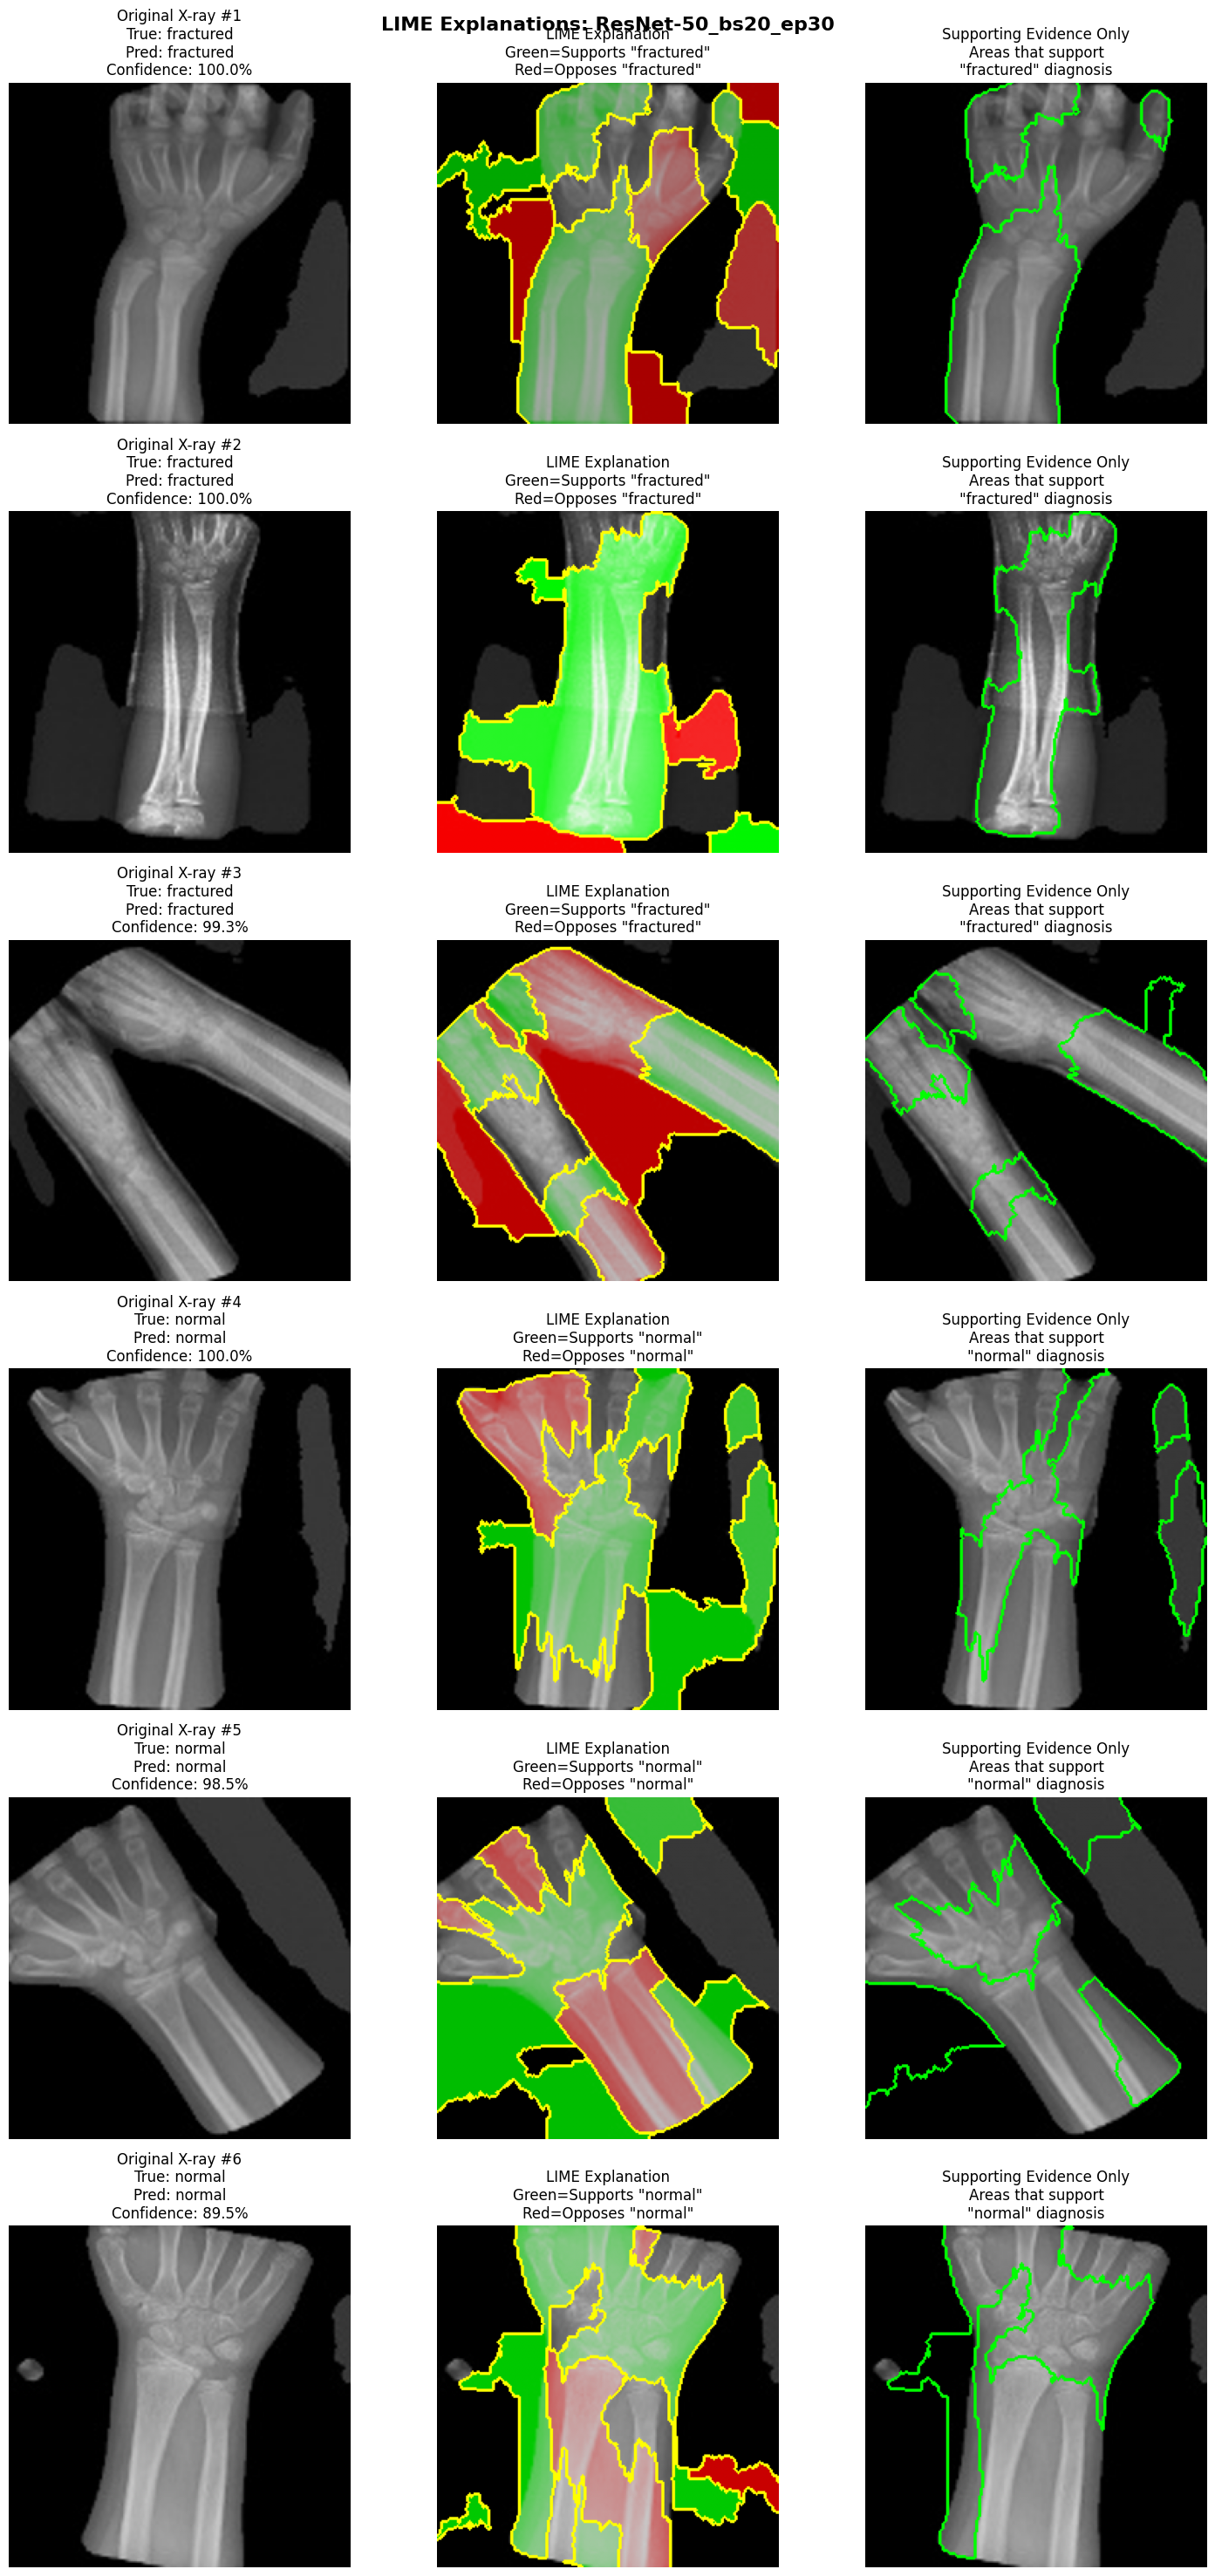


🏥 MEDICAL VALIDITY ANALYSIS

    📊 SUMMARY STATISTICS:
    - Total images analyzed: 6
    - Correct predictions: 6/6 (100.0%)
    - Average confidence: 97.9%
    - Average explanation coverage: 47.3%
    

    🔍 MEDICAL INTERPRETATION GUIDELINES:
    
    ✅ GOOD SIGNS (Model focusing on relevant anatomy):
    - Highlighted regions on bone structures
    - Focus on cortical bone lines and edges
    - Attention to joint spaces and alignment
    - Areas where fractures commonly occur (distal radius, metacarpals, phalanges)
    - Density variations in bone tissue
    
    ❌ CONCERNING SIGNS (Model might be using shortcuts):
    - Focus on text, labels, or annotations
    - Attention to medical equipment or positioning aids
    - Background artifacts or non-anatomical features
    - Patient identifiers or technical markers
    
    📝 EVALUATION CRITERIA:
    1. Anatomical Relevance: Do highlighted areas correspond to bone structures?
    2. Medical Logic: Do the explanations align with fra

In [ ]:
# =============================================================================
# LIME MODEL EXPLANATION - FRACTURE DETECTION ANALYSIS
# =============================================================================

print("🔬 LIME Explanation Analysis for Fracture Detection")
print("=" * 60)

# Configuration
NUM_SAMPLES = 6  # Number of test images to explain
LIME_SAMPLES = 1500  # Number of samples for LIME (higher = more accurate)
NUM_FEATURES = 15  # Number of superpixels to show in explanation

# =============================================================================
# LIME PREDICTION FUNCTION
# =============================================================================

def predict_fn_for_lime(images):
    """Optimized prediction function for LIME"""

    # Handle single image
    if len(images.shape) == 3:
        images = images[np.newaxis, ...]

    # Normalization transform
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    predictions = []
    best_model.eval()

    with torch.no_grad():
        for img in images:
            # Convert numpy array to tensor and normalize
            if img.max() > 1.0:  # If image is in [0, 255] range
                img = img / 255.0

            img_tensor = torch.FloatTensor(img).permute(2, 0, 1)  # HWC to CHW
            img_tensor = normalize(img_tensor).unsqueeze(0).to(device)

            # Get prediction
            output = best_model(img_tensor)
            prob = F.softmax(output, dim=1)
            predictions.append(prob.cpu().numpy()[0])

    return np.array(predictions)

# =============================================================================
# SAMPLE SELECTION AND ANALYSIS
# =============================================================================

def get_diverse_samples(num_samples=6):
    """Get diverse sample images including both classes and confidence levels"""

    print(f"🎯 Selecting {num_samples} diverse test images...")

    # Get predictions for all test images first
    test_predictions = []
    test_confidences = []
    test_indices = []

    best_model.eval()
    with torch.no_grad():
        for idx in range(min(100, len(test_dataset))):  # Check first 100 images
            # Get image
            img_path = test_dataset.dataset.samples[test_dataset.indices[idx]][0]
            img = Image.open(img_path).convert('RGB').resize((224, 224))

            # Transform for model
            img_tensor = val_transform(img).unsqueeze(0).to(device)

            # Predict
            output = best_model(img_tensor)
            prob = F.softmax(output, dim=1)
            pred_class = torch.argmax(prob, dim=1).item()
            confidence = prob[0][pred_class].item()

            test_predictions.append(pred_class)
            test_confidences.append(confidence)
            test_indices.append(idx)

    # Select diverse samples
    selected_indices = []

    # Get samples from each class
    for class_idx in [0, 1]:  # normal, fractured
        class_samples = [(i, conf) for i, (pred, conf) in enumerate(zip(test_predictions, test_confidences))
                        if pred == class_idx]

        if class_samples:
            # Sort by confidence and pick diverse samples
            class_samples.sort(key=lambda x: x[1], reverse=True)

            # Pick high and medium confidence samples
            samples_to_pick = min(num_samples // 2, len(class_samples))
            for i in range(samples_to_pick):
                idx = class_samples[i * (len(class_samples) // samples_to_pick)][0]
                selected_indices.append(test_indices[idx])

    # Fill remaining slots randomly if needed
    while len(selected_indices) < num_samples and len(selected_indices) < len(test_indices):
        remaining = [i for i in test_indices if i not in selected_indices]
        if remaining:
            selected_indices.append(random.choice(remaining))

    return selected_indices[:num_samples]

def explain_with_lime():
    """Generate comprehensive LIME explanations"""

    print("🚀 Starting LIME explanation analysis...")

    # Get diverse sample images
    sample_indices = get_diverse_samples(NUM_SAMPLES)

    # Initialize LIME explainer
    explainer = lime_image.LimeImageExplainer(random_state=42)

    # Create figure
    fig, axes = plt.subplots(NUM_SAMPLES, 3, figsize=(15, 5*NUM_SAMPLES))
    fig.suptitle(f'LIME Explanations: {best_model_id}', fontsize=16, fontweight='bold')

    explanations_data = []

    for i, sample_idx in enumerate(sample_indices):
        print(f"📸 Analyzing image {i+1}/{NUM_SAMPLES}...")

        # Load image
        img_path = test_dataset.dataset.samples[test_dataset.indices[sample_idx]][0]
        img = Image.open(img_path).convert('RGB').resize((224, 224))
        img_array = np.array(img)

        # Get true label
        true_label = test_dataset.dataset.samples[test_dataset.indices[sample_idx]][1]

        # Get model prediction
        img_tensor = val_transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = best_model(img_tensor)
            probabilities = F.softmax(output, dim=1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
            confidence = probabilities[0][predicted_class].item()

        # Generate LIME explanation
        print(f"   🔬 Generating LIME explanation (using {LIME_SAMPLES} samples)...")
        explanation = explainer.explain_instance(
            img_array,
            predict_fn_for_lime,
            top_labels=2,
            hide_color=0,
            num_samples=LIME_SAMPLES,
            random_seed=42
        )

        # Get explanation for predicted class
        temp, mask = explanation.get_image_and_mask(
            predicted_class,
            positive_only=False,
            num_features=NUM_FEATURES,
            hide_rest=False
        )

        # Calculate explanation statistics
        positive_pixels = np.sum(mask > 0)
        negative_pixels = np.sum(mask < 0)
        total_pixels = mask.size

        # Store explanation data
        explanations_data.append({
            'image_idx': i+1,
            'true_label': class_names[true_label],
            'predicted_label': class_names[predicted_class],
            'confidence': confidence,
            'correct': true_label == predicted_class,
            'positive_pixels': positive_pixels,
            'negative_pixels': negative_pixels,
            'explanation_coverage': (positive_pixels + negative_pixels) / total_pixels
        })

        # Plot results
        if NUM_SAMPLES == 1:
            axes = [axes]

        # Original image
        axes[i][0].imshow(img_array)
        axes[i][0].set_title(f'Original X-ray #{i+1}\n'
                           f'True: {class_names[true_label]}\n'
                           f'Pred: {class_names[predicted_class]}\n'
                           f'Confidence: {confidence:.1%}')
        axes[i][0].axis('off')

        # LIME explanation
        axes[i][1].imshow(mark_boundaries(temp / 255.0, mask, color=(1, 1, 0), mode='thick'))
        axes[i][1].set_title(f'LIME Explanation\n'
                           f'Green=Supports "{class_names[predicted_class]}"\n'
                           f'Red=Opposes "{class_names[predicted_class]}"')
        axes[i][1].axis('off')

        # Positive features only
        temp_pos, mask_pos = explanation.get_image_and_mask(
            predicted_class,
            positive_only=True,
            num_features=NUM_FEATURES//2,
            hide_rest=False
        )

        axes[i][2].imshow(mark_boundaries(temp_pos / 255.0, mask_pos, color=(0, 1, 0), mode='thick'))
        axes[i][2].set_title(f'Supporting Evidence Only\n'
                           f'Areas that support\n'
                           f'"{class_names[predicted_class]}" diagnosis')
        axes[i][2].axis('off')

        # Print detailed analysis
        print(f"""
        📊 Image {i+1} Analysis:
        - True Label: {class_names[true_label]}
        - Predicted: {class_names[predicted_class]} ({confidence:.1%} confidence)
        - Correct: {'✅ Yes' if true_label == predicted_class else '❌ No'}
        - Supporting pixels: {positive_pixels:,} ({positive_pixels/total_pixels:.1%})
        - Opposing pixels: {negative_pixels:,} ({negative_pixels/total_pixels:.1%})
        """)

    plt.tight_layout()
    plt.show()

    return explanations_data, explainer

# =============================================================================
# MEDICAL ANALYSIS FRAMEWORK
# =============================================================================

def analyze_medical_validity(explanations_data):
    """Analyze the medical validity of LIME explanations"""

    print("\n" + "="*60)
    print("🏥 MEDICAL VALIDITY ANALYSIS")
    print("="*60)

    # Summary statistics
    total_images = len(explanations_data)
    correct_predictions = sum(1 for exp in explanations_data if exp['correct'])
    avg_confidence = np.mean([exp['confidence'] for exp in explanations_data])
    avg_coverage = np.mean([exp['explanation_coverage'] for exp in explanations_data])

    print(f"""
    📊 SUMMARY STATISTICS:
    - Total images analyzed: {total_images}
    - Correct predictions: {correct_predictions}/{total_images} ({correct_predictions/total_images:.1%})
    - Average confidence: {avg_confidence:.1%}
    - Average explanation coverage: {avg_coverage:.1%}
    """)

    print("""
    🔍 MEDICAL INTERPRETATION GUIDELINES:

    ✅ GOOD SIGNS (Model focusing on relevant anatomy):
    - Highlighted regions on bone structures
    - Focus on cortical bone lines and edges
    - Attention to joint spaces and alignment
    - Areas where fractures commonly occur (distal radius, metacarpals, phalanges)
    - Density variations in bone tissue

    ❌ CONCERNING SIGNS (Model might be using shortcuts):
    - Focus on text, labels, or annotations
    - Attention to medical equipment or positioning aids
    - Background artifacts or non-anatomical features
    - Patient identifiers or technical markers

    📝 EVALUATION CRITERIA:
    1. Anatomical Relevance: Do highlighted areas correspond to bone structures?
    2. Medical Logic: Do the explanations align with fracture detection principles?
    3. Consistency: Are explanations consistent across similar cases?
    4. Clinical Utility: Would these explanations help a radiologist?
    """)

    # Detailed analysis for each prediction type
    fractured_explanations = [exp for exp in explanations_data if exp['predicted_label'] == 'fractured']
    normal_explanations = [exp for exp in explanations_data if exp['predicted_label'] == 'normal']

    if fractured_explanations:
        print(f"\n🦴 FRACTURED PREDICTIONS ({len(fractured_explanations)} images):")
        for exp in fractured_explanations:
            status = "✅" if exp['correct'] else "❌"
            print(f"   {status} Image {exp['image_idx']}: {exp['confidence']:.1%} confidence")

    if normal_explanations:
        print(f"\n✅ NORMAL PREDICTIONS ({len(normal_explanations)} images):")
        for exp in normal_explanations:
            status = "✅" if exp['correct'] else "❌"
            print(f"   {status} Image {exp['image_idx']}: {exp['confidence']:.1%} confidence")

# =============================================================================
# EXECUTION
# =============================================================================

if 'best_model' in globals() and 'best_model_id' in globals():
    print(f"🎯 Using model: {best_model_id}")
    print(f"📊 Device: {device}")

    # Run LIME analysis
    explanations_data, lime_explainer = explain_with_lime()

    # Analyze medical validity
    analyze_medical_validity(explanations_data)

    print(f"""
    ✅ LIME ANALYSIS COMPLETE!

    📋 FOR YOUR REPORT, INCLUDE:
    1. The LIME visualization plots showing original images and explanations
    2. Discussion of whether highlighted regions are anatomically relevant
    3. Analysis of model focus on bone structures vs artifacts
    4. Medical validity assessment of the explanations

    💡 KEY POINTS TO DISCUSS:
    - LIME provides local explanations for individual predictions
    - Green regions support the predicted class, red regions oppose it
    - Model interpretability is crucial for medical AI adoption
    - Explanations should align with radiological knowledge
    """)

else:
    print("❌ Error: Best model not loaded. Please run the model loading block first.")